In [105]:
import os
import glob
import numpy as np
import soundfile as sf
from essentia.standard import *
import matplotlib.pyplot as plt

from tqdm import tqdm
from essentia.standard import *
from scipy.signal import butter, lfilter
from scipy.interpolate import make_interp_spline, BSpline

eps = np.finfo(np.float64).eps

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

In [36]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [127]:
def normalized_mean_spectrum(audio_file, ratio_idxs, fs=22050, harmonic=False):
    
    # note: this function is still too slow, we need to optimize it more
    
    # we start by instantiating the audio loader
    loader = essentia.standard.MonoLoader(filename=audio_file, sampleRate=fs)

    # and then we actually perform the loading
    audio = loader()
    
    # apply a lowpass filter to focus on speeech
    lowpass = LowPass(cutoffFrequency=8000, sampleRate=fs)
    audio = lowpass(audio)
    
    # Some configuration parameters
    N = 2048
    H = N//2
    fMax = 5000
    fMin = 50
    w = Windowing(type='blackmanharris92')
    ratio_density = len(ratio_idxs)
    
    spectrum = Spectrum()
    
    spectralPeaks = SpectralPeaks(magnitudeThreshold=-80,
                                  maxFrequency=fMax,
                                  maxPeaks=N//2,
                                  minFrequency=fMin,
                                  sampleRate=fs) 
    
    harmonicPeaks = HarmonicPeaks(maxHarmonics=20,
                                  tolerance=0.2)
    
    pitchYin = PitchYin(frameSize=N,
                        interpolate=True,
                        maxFrequency=fMax,
                        minFrequency=fMin,
                        sampleRate=fs,
                        tolerance=0.15)
       
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize=N, hopSize=H, startFromZero=True):
        
        p, pConf = pitchYin(frame)
        dBSpectrum = 20 * np.log10(spectrum(w(frame)) + eps)
        freqs, magsdB = spectralPeaks(dBSpectrum)
        
        if harmonic:
            hFreqs, hMags = harmonicPeaks(freqs, magsdB, p)
            pool.add('hFreqs', hFreqs)
            pool.add('hMags',  hMags)

        pool.add('freqs',  freqs)
        pool.add('magsdB', magsdB)
        pool.add('magsLn', np.power(10, magsdB/20))
        pool.add('p',      p)
        pool.add('pConf',  pConf)

                     
    freq_data_mean_ln = np.zeros(shape=(ratio_density,))
    
    if harmonic:
        vFreqs = pool['hFreqs']
        vMags  = pool['hMags']
    else:
        vFreqs = pool['freqs']
        vMags  = pool['magsLn']
    
    for freqs, mags, p, pConf in zip(vFreqs, vMags, pool['p'], pool['pConf']):
        # skip if no f0 found
        if pConf <= 0.0:
            continue
            
        # there is some consideration needed here
        # do we want to skip frames without a clear fundamental?
        # this means that we examine only voiced speech
        
        # skip if no peaks are found
        if len(freqs) < 1 or len(mags) < 1:
            continue
        
        f0_freq = p #freqs[np.argmax(mags)]
        
        for peak_freq, peak_mag in zip(freqs, mags):
            
            # calculate current ratio w.r.t to fundamental
            current_ratio = peak_freq / f0_freq
            
            if current_ratio > 3.0:
                # find closest octave ratio
                octave_ratio = np.floor(current_ratio/2) * 2
            else:
                octave_ratio = 1
            
            # scale harmonics between the range of [1.0, 2.0]
            relative_ratio = current_ratio / octave_ratio
            
            ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, relative_ratio)))
            freq_data_mean_ln[ratio_idx] += peak_mag
    
    # normalize
    freq_data_mean_ln /= freq_data_mean_ln.shape[0]
    
    return freq_data_mean_ln


In [128]:
def plot_mean_spectrum(ratio_idx, freq_data_mean_db):
    
    common = [1/1, 6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
    
    plt.plot(ratio_idx, freq_data_mean_db, c='r', zorder=2)
    #for ratio in common:
    #    plt.axvline(ratio_idx[np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))],
    #                c='k', zorder=1, linewidth=0.5)
    plt.xticks(common, rotation=70)
    plt.xlim([0.95, 2.1])
    plt.ylim([-40,3])
    plt.ylabel('Mean amplitude (dB)')
    plt.xlabel('f0 ratio')
    plt.grid()
    plt.show()
    #plot_path = os.path.join('plots', os.path.basename(audio_file).replace('flac', 'png'))
    #plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [129]:
def analyze_dataset(audio_files):
    
    if len(audio_files) < 1:
        print("No audio files...")
        return
    
    ratio_density = 200
    ratio_start = 0.0
    ratio_stop  = 3.0
    ratio_idxs = np.linspace(ratio_start, ratio_stop, ratio_density)
    
    freq_data_mean_ln = np.zeros(ratio_density)
    
    for audio_file in tqdm(audio_files):
        freq_data_mean_ln += normalized_mean_spectrum(audio_file, ratio_idxs)
        
    freq_data_mean_ln /= len(audio_files)
    freq_data_mean_db = 20 * np.log10((freq_data_mean_ln + eps)/np.max(freq_data_mean_ln + eps))
    
    
    # interpolate for smooth curve
    # note: this isn't the smartest way to achieve this
    # we should really try to do some kind of interpolation when
    # we are sorting the frequency bins into the ratios
    
    xnew = np.linspace(ratio_idxs.min(),ratio_idxs.max(), 10000) 
    spl = make_interp_spline(ratio_idxs, freq_data_mean_db, k=3)
    freq_data_mean_db_smooth = spl(xnew)
    
    plot_mean_spectrum(xnew, freq_data_mean_db_smooth)
    #plot_mean_spectrum(ratio_idxs, freq_data_mean_db)
    
    
    

100%|██████████| 1/1 [00:10<00:00, 10.07s/it]


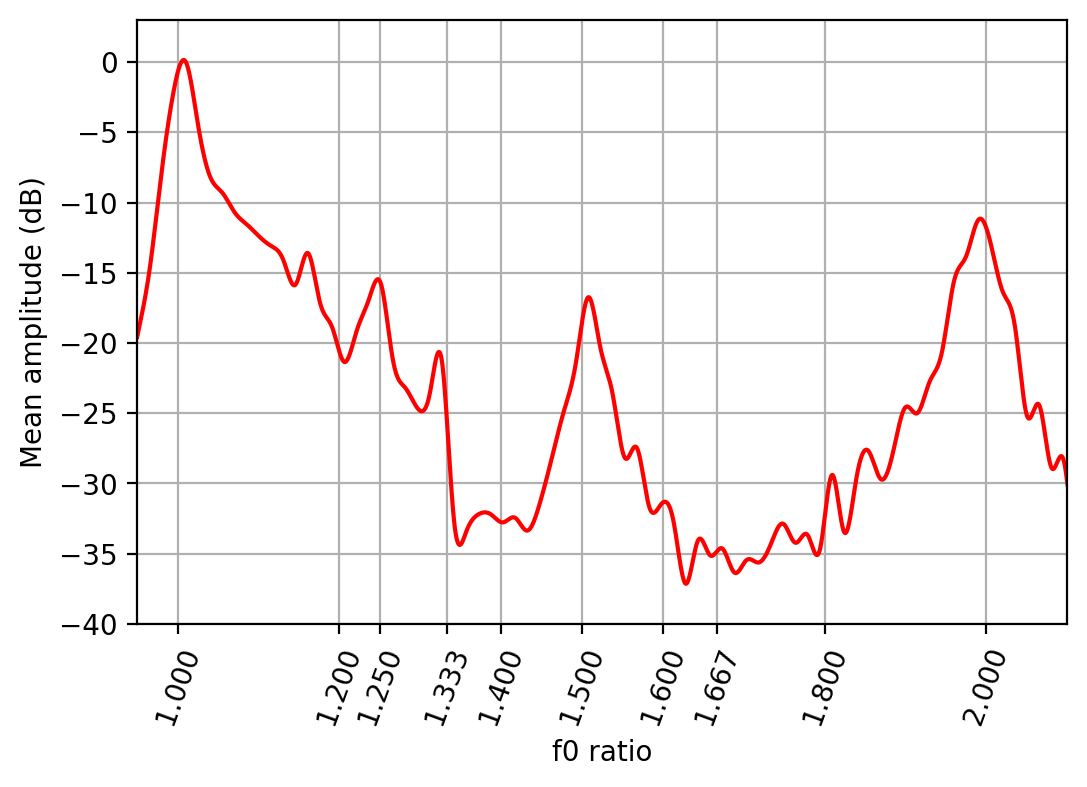

In [130]:
javanese1 = 'audio/nila_speaking_javanese.wav'
analyze_dataset([javanese1])

100%|██████████| 1/1 [00:32<00:00, 32.11s/it]


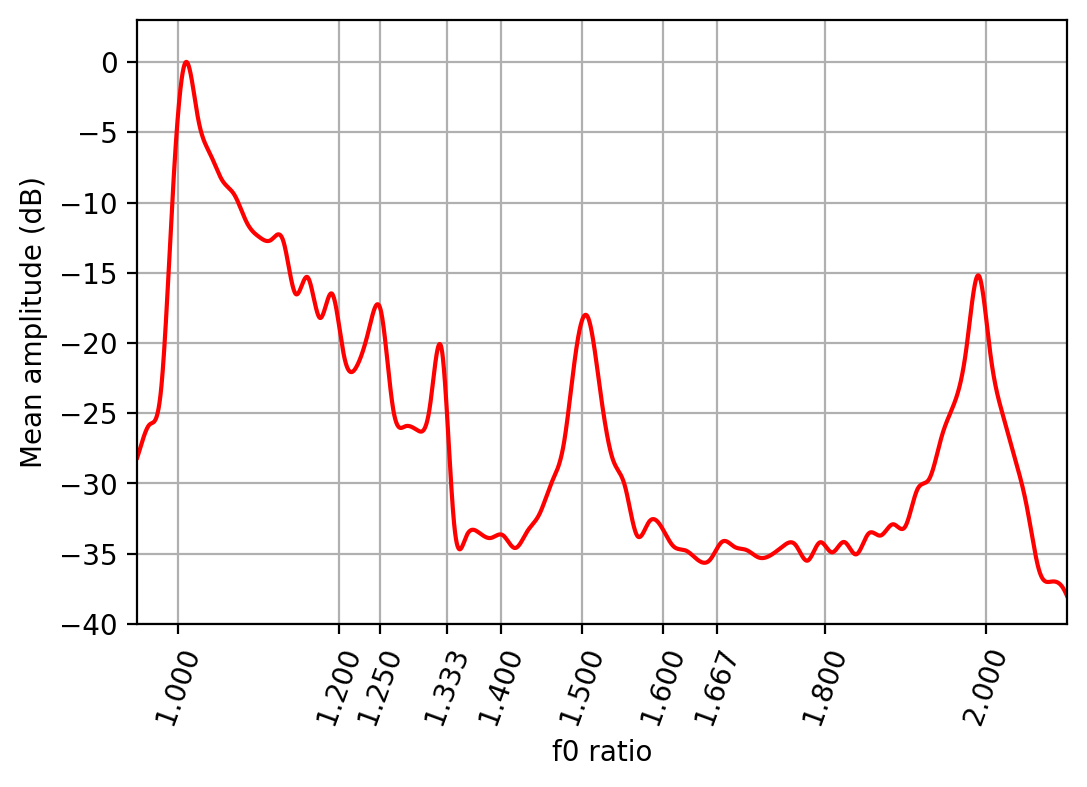

In [131]:
javanese2 = 'audio/rama_speaking_javanese.wav'
analyze_dataset([javanese2])

100%|██████████| 1/1 [00:20<00:00, 20.87s/it]


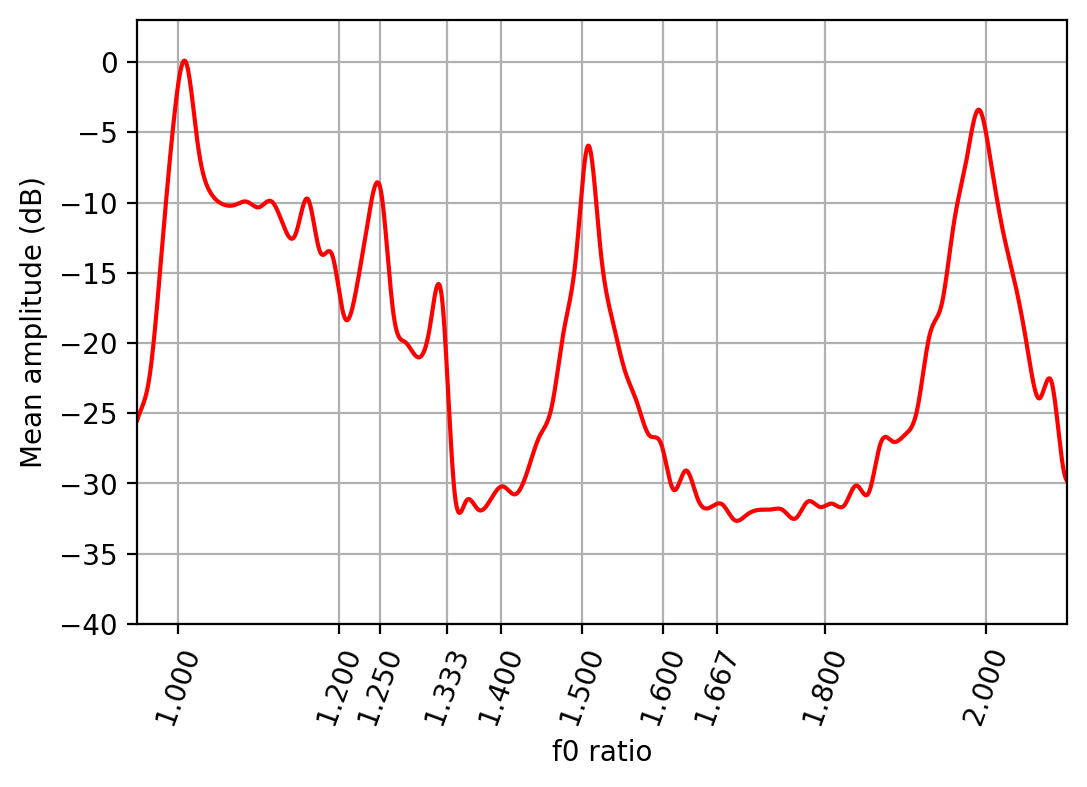

In [132]:
catalan = 'audio/ona_speaking_catalan.wav'
analyze_dataset([catalan])

100%|██████████| 1/1 [00:22<00:00, 22.09s/it]


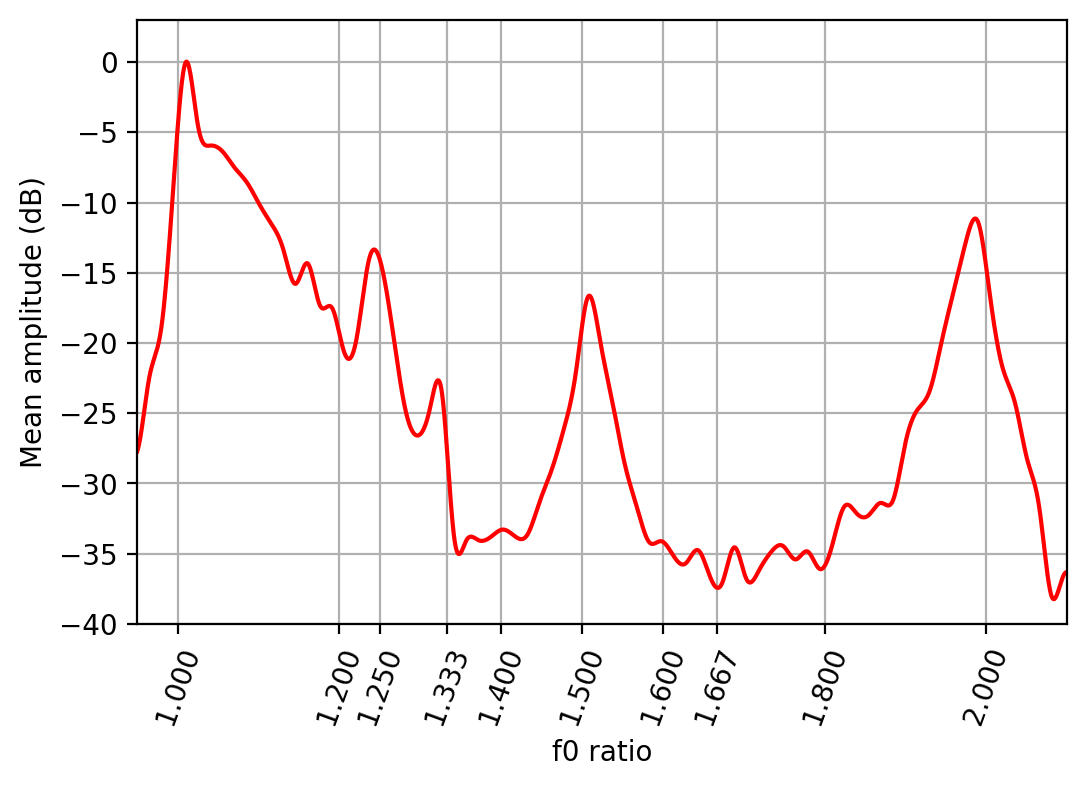

In [133]:
english = 'audio/liam_speaking_english.wav'
analyze_dataset([english])

100%|██████████| 4/4 [01:11<00:00, 17.85s/it]


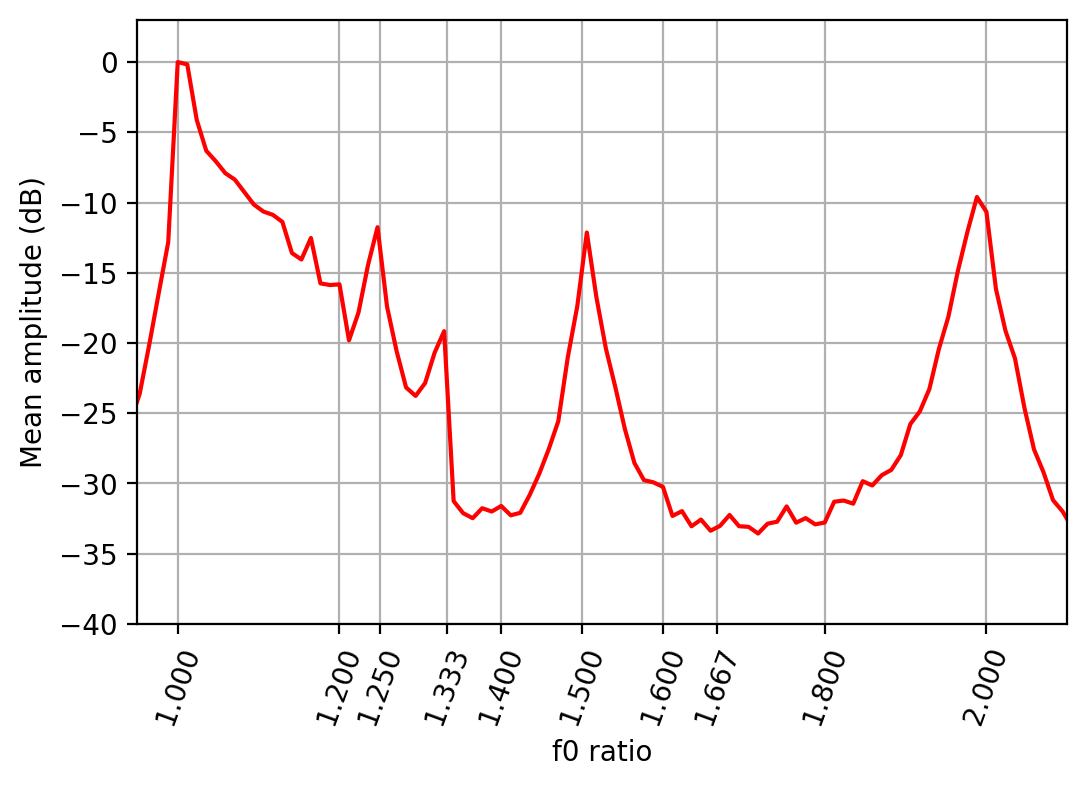

In [93]:
analyze_dataset([javanese1, javanese2, catalan, english])

In [36]:
chinese = glob.glob('/Volumes/SteinmetzAlpha/Datasets/chinese-single-speaker-speech-dataset/**/*.wav')[:10000]

In [ ]:
analyze_dataset(chinese)

100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


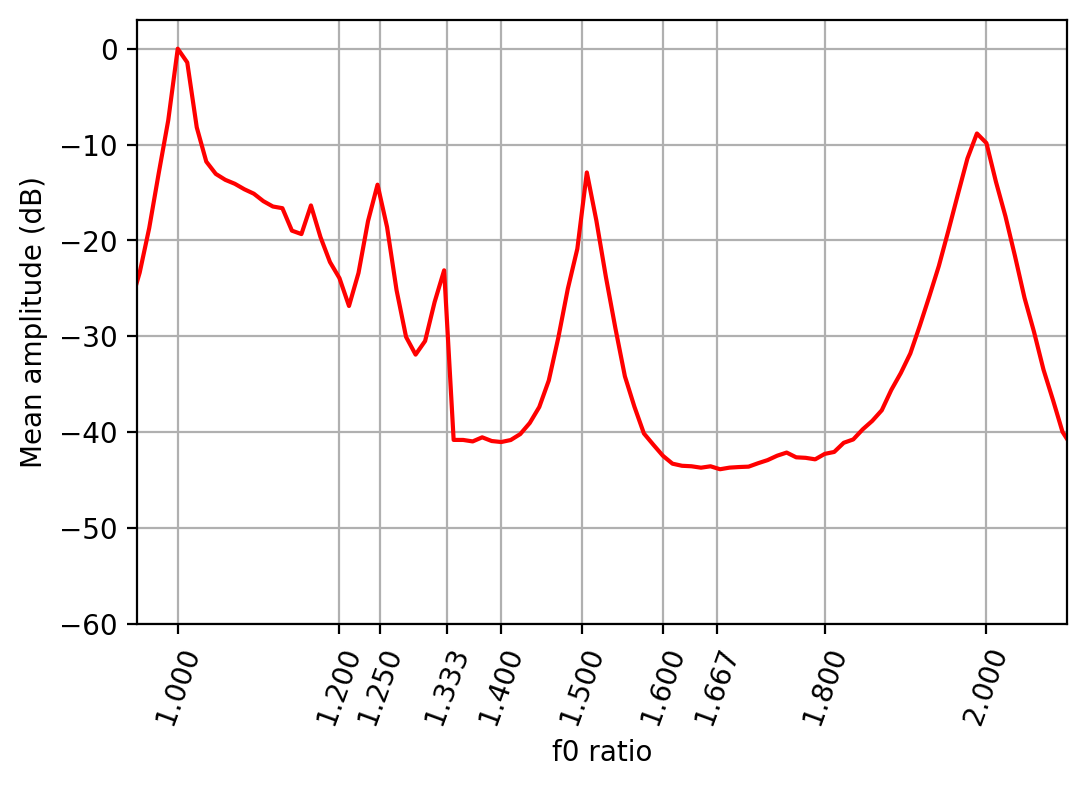

In [32]:
libri = glob.glob('/Volumes/SteinmetzAlpha/Datasets/LibriSpeech/dev-clean/**/**/*.flac')[:1000]
analyze_dataset(libri)

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


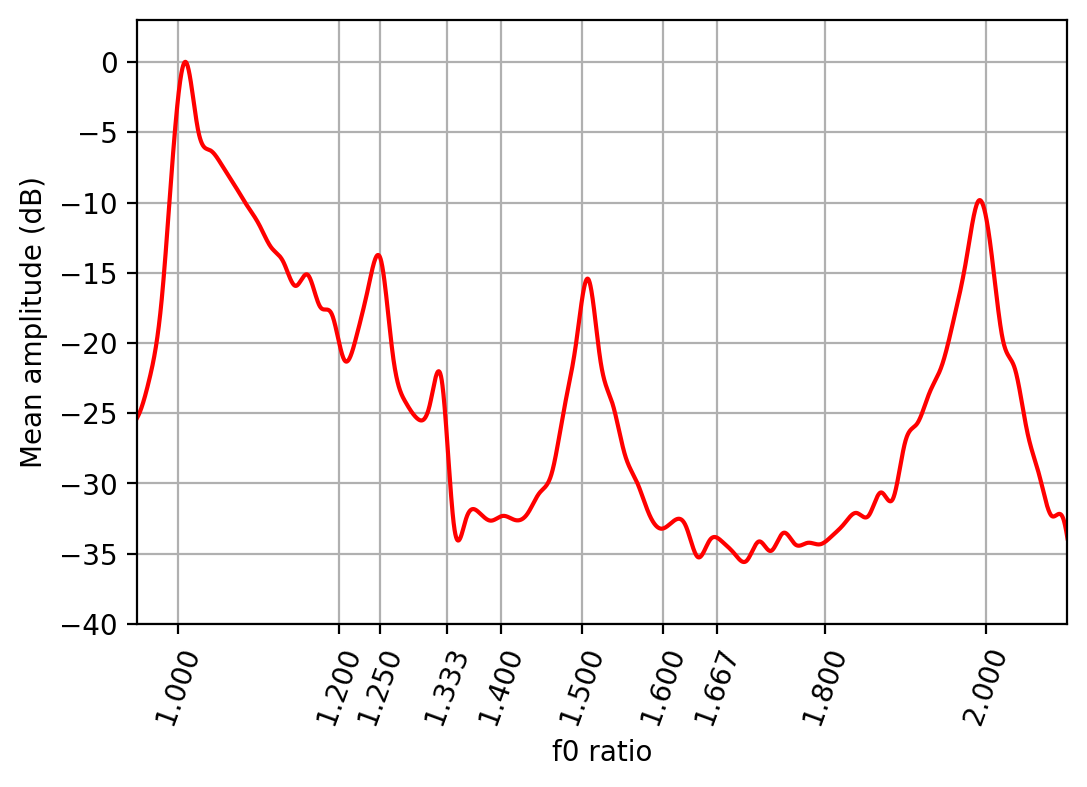

In [134]:
common = glob.glob('/Volumes/SteinmetzAlpha/Datasets/Speech/en/clips/*.mp3')[:100]
analyze_dataset(common)
